# Group Project: Movie Recommendations (2487-T2 Machine Learning) [Group 2]
- Nova School of Business and Economics, Portugal
- Instructor: Qiwei Han, Ph.D.
- Program: Masters Program in Business Analytics
- Group Members: 
    - **Luca Silvano Carocci (53942)**
    - **Fridtjov Höyerholt Stokkeland (52922)**
    - **Diego García Rieckhof (53046)**
    - **Matilde Pesce (53258)**
    - **Florian Fritz Preiss (54385)**<br>
---
# Phase 2: Data Understanding [03 Exploratory Data Analysis (EDA)]

Performing a thorough exploratory data analysis (EDA) will help to both assess the feasibility of the dataset for our use-case and uncover underlying patterns in the datasets that can be leveraged for feature engineering in the next steps of the project.

In this EDA, we will analyze two data tables created in the 01_data-wrangling notebook. The columns of the tables and their descriptions are listed below:
* **Pre-Processed Ratings Table (prepr_ratings.csv)**: A table containing ~25M ratings of ~50k movies by ~160k users
	* 'userId': The unique identifier of the user who submitted the rating.
    * 'movieId': The unique identifier of each movie.
    * 'rating': The rating the user assigned to the movie between 0.5 (lowest) and 5.0 (highest) in 0.5 intervals.
    * 'timestamp': The date and time at which the rating has been submitted.
* **Pre-Processed Movies Table (prepr_movies.csv)**: A table containing detailed information on all of the ~50k rated movies
	* 'movieId': The unique identifier of each movie.
    * 'title': The title of the movie.
    * 'genres': A list of genres the movie has been assigned to.
    * 'year': The year of publication of the movie.
    * 'tmdbId': The unique identifier of each movie in the TMDB database (https://www.themoviedb.org/).
    * 'tag': A list of tags that have been assigned to each movie (a tag is assigned to a movie if at least one user has assigned the tag to the movie)
    * 'collection_name': The name of the collection the movie is part of (NaN-values are not part of any collection)
    * 'original_language': The original language of the movie.
    * 'description': A short description of the movie plot.
    * 'runtime': The duration of the movie in minutes.
    * 'actors': A list containing the top 3 most popular actors starring in the movie according to the popularity index by TMDB (https://www.themoviedb.org/).
    * 'director': The director(s) of the movie.
    * 'production_countries': The countries in which the movie has been produced.
    * 'spoken_languages': A list of the languages spoken in the movie.
    * 'description_cleaned': A cleaned version of the description text.
    * 'description_cleaned_wsw': The cleaned description text with all stop-words removed.
    * 'description_nwords': The wordcount of the movie plot description text.
    * 'description_nwords_wsw': The wordcount of the movie plot description text without excluding stopwords.
    * 'description_nwords_unique': The count of unique words used in the movie plot description.
    * 'description_nstopwords': The count of stopwords used in the movie plot description.
    * 'description_diff_nwords': The difference between the number of words in 'description_nwords' and the number of stopwords.
    * 'description_meanword': The average word length in the 'description_cleaned' column.
    * 'description_meanword_wsw': The average word length in the 'description_cleaned_wsw' column which has stopwords removed
    * 'description_nchars':  The total number of characters in the 'description_cleaned' column.
    * 'description_nchars_wsw': The total number of characters in the 'description_cleaned_wsw' column which has stopwords removed.
    * 'description_diff_nchars': The difference between the number of characters in 'description_nchars' and the number of characters in 'description_nchars_wsw'.
    * 'description_root_wrds': The root words (also known as base words, stems, or lemmas) for the words in the movie descriptions.
    * 'description_jj_n': The total count of adjectives (JJ) in the movie descriptions.
    * 'description_nn_n': The total count of nouns (NN) in the movie descriptions. 
    * 'description_prp_n': The total count of pronouns (PRP) in the movie descriptions.
    * 'description_rb_n': The total count of adverbs (RB) in the movie descriptions. 
    * 'description_vb_n': The total count of verbs (VB) in the movie descriptions. 
   

## 1. Ratings Table

In [1]:
import ast
import collections
import os
import re
import string
import random

from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from nltk.util import ngrams
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator
import nltk

In [2]:
# Importing the ratings table
ratings_df = pd.read_csv('../00_Data/01_processed/prepr_ratings.csv',
                         dtype={'userId': object, 'movieId': object})

ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s', origin='unix')
ratings_df = ratings_df.drop('Unnamed: 0', axis=1)
ratings_df.head()

userId movieId  rating           timestamp
0      1     296     5.0 2006-05-17 15:34:04
1      1     306     3.5 2006-05-17 12:26:57
2      1     307     5.0 2006-05-17 12:27:08
3      1     665     5.0 2006-05-17 15:13:40
4      1     899     3.5 2006-05-17 12:21:50

In [3]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24734765 entries, 0 to 24734764
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     object        
 1   movieId    object        
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 754.8+ MB


There are about 24.7 million ratings present in the dataset and the information for all of them is complete in the dataset.

In [4]:
ratings_df.describe()

rating
count  2.473476e+07
mean   3.534142e+00
std    1.060237e+00
min    5.000000e-01
25%    3.000000e+00
50%    3.500000e+00
75%    4.000000e+00
max    5.000000e+00

The rating scale is between 0.5 (lowest) and 5.0 (highest) in intervals of 0.5. Interestingly, the average rating is rather high (> 3.5), potentially indicating that users persent in the dataset either select the movies they watch carefully or that there is a higher motivation to submit ratings after a positive experience than after a negative experience.

### 1.1 Number of Ratings by Users (userId column)

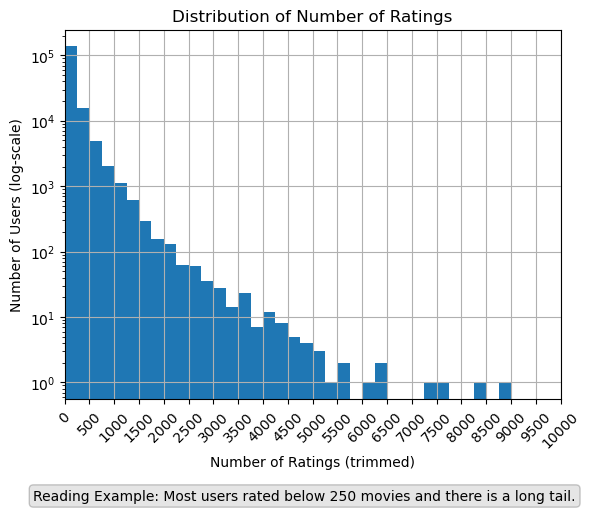

In [5]:
# Get distribution of ratings by user (How many ratings did each user submit?)
ratings_per_user = ratings_df.groupby('userId').agg({'rating':'count'}).sort_values('rating', ascending=False)

fig, ax = plt.subplots() 

plt.hist(ratings_per_user, range=(0,10000), bins=40)
plt.grid()
plt.title('Distribution of Number of Ratings')
plt.ylabel('Number of Users (log-scale)')
plt.yscale('log')
plt.xlabel('Number of Ratings (trimmed)')
plt.xticks([n*500 for n in range(21)], rotation=45)
plt.xlim(0,10000)

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
text = fig.text(0.50, -.1,
                'Reading Example: Most users rated below 250 movies and there is a long tail.',
                horizontalalignment='center', wrap=True, bbox=props);

Most Users rated a rather small amount of movies (under 250) and there is a very long tail, i.e., the distribution is highly right skewed. However, for a ratings based recommender system, it is important to have many users with a substantial amount of interactions, i.e., rating submissions. Let's take a closer look:

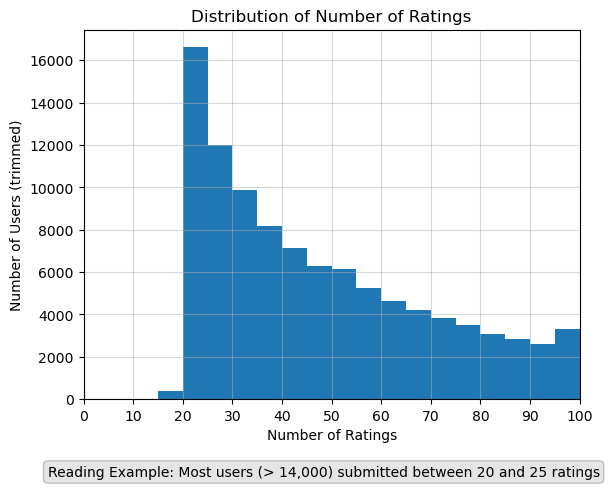

In [6]:
fig, ax = plt.subplots()

plt.hist(ratings_per_user, bins=20, range=(0, 100))
plt.grid(alpha=.5)
plt.title('Distribution of Number of Ratings')
plt.xlabel('Number of Ratings')
plt.xlim(0, 100)
plt.xticks([n*10 for n in range(11)])
plt.ylabel('Number of Users (trimmed)')

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
text = fig.text(0.50, -.05,
                'Reading Example: Most users (> 14,000) submitted between 20 and 25 ratings',
                horizontalalignment='center', wrap=True, bbox=props);

There are almost no users that rated less than 20 movies, which looks promising for building a ratings-based recommender system. However, seing a distribution of what percentage of users rated more that n movies would help to get an even better understanding uf the distribution.

In [7]:
def instances_n_observations(data, range_):
    """
    Takes a table grouped by a specifc instance (index) and the count of occurences of that instance (column)
    and a range to calculate, for each number (n) in the range, both the number and the percentage of instances
    that have equally as many or more obeservations then the number (n). 
    
    Parameters:
    ------------
    data: pandas.core.frame.DataFrame
    	A pandas dataframe with the name or ID of the instance as index column and one column with the number
        of occurences of that instance. 
    
    range_: range
    	A range specifying the start, end, and stepsize of number n to run the calculation for.
    
    Returns:
    ------------
    num_observations: pandas.core.frame.DataFrame
    	A dataframe with all nubmbers n and, for each n, the absolute number as well as the percentage of all
        instances that have equal or more than n occurences in the original data.
    """
    try:
        if type(range_) == int:
            a = range(range_)
        elif len(range_) == 2:
            a = range(range_[0], range_[1])
        elif len(range_) == 3:
            a = range(range_[0], range_[1], range_[2])
    except:
        raise TypeError('Pass a tuple of 1 to 3 integers.')

    num_observations = {'n': [], 'instances with >= n observations (abs)': [], 'instances with >= n observations (%)': []}
    
    for n in a:
        num_observations['n'].append(n)
        num_observations['instances with >= n observations (abs)'].append(len(data[data.iloc[:, 0] >= n]))
        num_observations['instances with >= n observations (%)'].append(len(data[data.iloc[:, 0] >= n])/len(data)*100)
    
    return pd.DataFrame(num_observations)

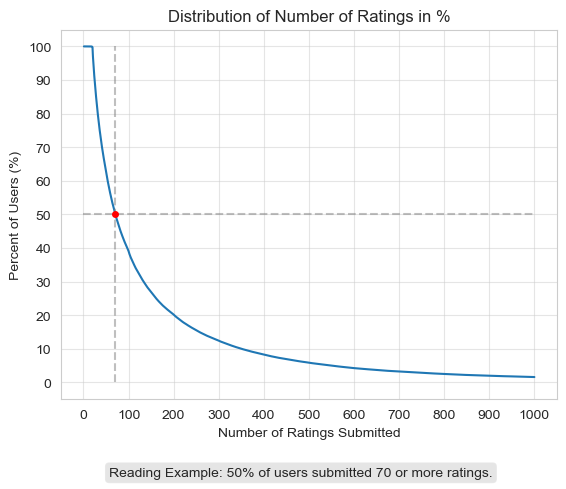

In [45]:
# for each number n between 1 and 1000, get the percentage of users that rated more than n movies.
users_n_ratings = instances_n_observations(data=ratings_per_user, range_=(1, 1001, 1))

fig, ax = plt.subplots()

plt.plot(users_n_ratings['n'],
         users_n_ratings['instances with >= n observations (%)'])
plt.title('Distribution of Number of Ratings in %')
plt.grid(alpha=.5)
plt.xlabel('Number of Ratings Submitted')
plt.xticks([n*100 for n in range(11)])
plt.ylabel('Percent of Users (%)')
plt.yticks([n*10 for n in range(11)])
plt.hlines(50, 0, 1000, color='gray', linestyle='--', alpha=.5)
plt.vlines(70, 0, 100, color='gray', linestyle='--', alpha=.5)
plt.plot(70, 50, marker='o', color='r', markersize=4)

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
text = fig.text(0.50, -.05, 'Reading Example: 50% of users submitted 70 or more ratings.',  horizontalalignment='center', wrap=True, bbox=props);

In fact, 50% of users submitted 70+ ratings and about 10% even 350+. These numbers confirm the quality and suitability of the dataset.

### 1.2 Distribution of Ratings and Ratings over Time (ratings column & timestamp column)

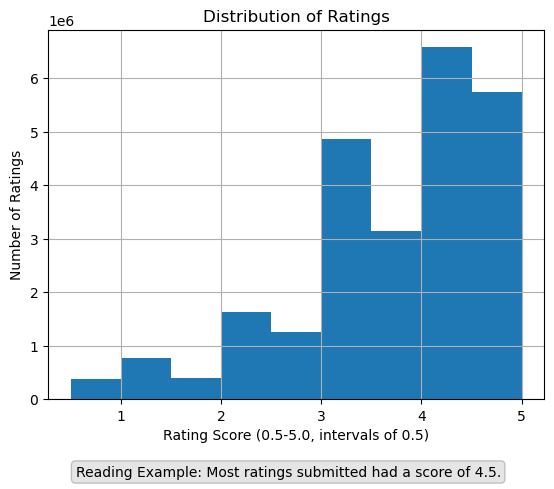

In [9]:
# Show distribution of rating submissions
fig, ax = plt.subplots()

plt.hist(ratings_df['rating'], range=(0.5,5), bins=9)
plt.title('Distribution of Ratings')
plt.grid()
plt.xlabel('Rating Score (0.5-5.0, intervals of 0.5)')
plt.ylabel('Number of Ratings')

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
text = fig.text(0.50, -.05, 'Reading Example: Most ratings submitted had a score of 4.5.',
                horizontalalignment='center', wrap=True, bbox=props);

As stated previously, the average rating is rather high (> 3.5) and most ratings submitted assigned a score of 4.5. This shows that users tend to rate the movies they rate quite positive overall, potentially indicating that users persent in the dataset either select the movies they watch carefully or that there is a higher motivation to submit ratings after a positive experience than after a negative experience. The bi-modal distribution indicates that users rarely opt for rating a movie as 4.0. This is an interesting threshold of deciding between liked and disliked movies. Therefore, we will calcuate the precision based on ratings >= 4.0 in the model evaluation, i.e., interpret a movie as 'liked' by a user if the user assigned a rating >= 4.0.

Now, let's take a look at how the ratings in our dataset evolved over time.

In [10]:
# Get count of ratings and average score for each year in the dataset
ratings_by_year = ratings_df.groupby(ratings_df['timestamp'].dt.strftime('%Y')).agg({'rating': ['count', 'mean']})

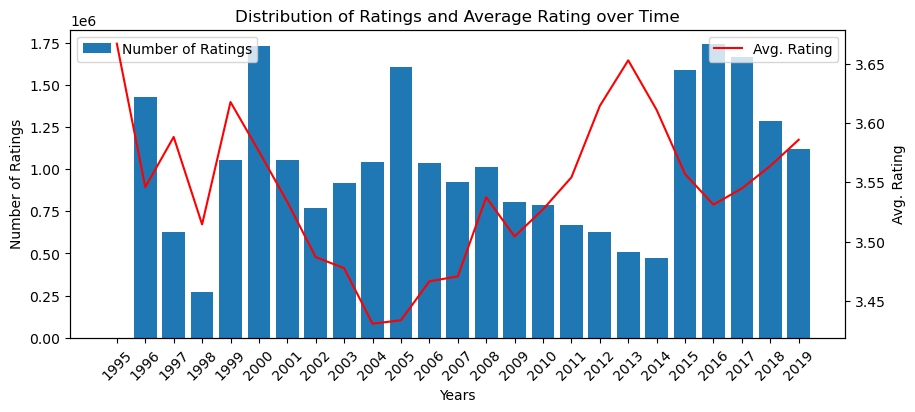

In [11]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

ax1.bar(ratings_by_year.index, height=ratings_by_year.iloc[:,0], label='Number of Ratings')
ax1.legend(loc='upper left')
ax1.set_xlabel('Years')
ax1.set_ylabel('Number of Ratings')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(ratings_by_year.iloc[:,1], 'r', label='Avg. Rating')
ax2.legend(loc='upper right')
ax2.set_ylabel('Avg. Rating')

plt.title('Distribution of Ratings and Average Rating over Time');

We are looking at ratings submitted between 01-01-1995 and 31-12-2019. The number of ratings per year fluctuates quite considerably. Interestingly, the second lowest average rating was assigned in a year with quite many ratings present in the dataset while the period between 2012 and 2014, where the average rating peaked, have quite few observations. All in all, there a quite a lot of fluctuations that are hard to explain and there is no clear trend available of how ratings have evolved over time. 

## 2. Movies Table

In [12]:
# Import movies table and ensure data readiness for further processing
movies_df = pd.read_csv('../00_Data/01_processed/prepr_movies.csv',
                        lineterminator='\n',
                        dtype={'movieId': object, 'tmdbId': object},
                        converters={'production_countries': ast.literal_eval,
                                    'spoken_languages': ast.literal_eval})

movies_df = movies_df.drop('Unnamed: 0', axis=1)
movies_df['year'] = pd.to_datetime(movies_df['year'], format='%Y')
movies_df['genres'] = movies_df['genres'].apply(lambda x: ast.literal_eval(str(x)))
movies_df.loc[pd.isnull(movies_df['director']), 'director'] = 'None'
movies_df['director'] = movies_df['director'].apply(lambda x: ast.literal_eval(str(x)))

def read_as_list(list_as_string):
    """Converts \'tag\' column to list as commas where missing after re-importing+
    the dataset"""
    try:
        lst = ast.literal_eval(re.sub(r"'\s+'", "', '", list_as_string))
    except:
        lst = np.nan
    return lst
    
movies_df['tag'] = movies_df['tag'].apply(lambda x: read_as_list(x))

movies_df.loc[pd.isnull(movies_df['actors']), 'actors'] = 'None'
movies_df['actors'] = movies_df['actors'].apply(lambda x: ast.literal_eval(str(x)))
movies_df.head()

movieId                               title  \
0       1                    Toy Story (1995)   
1       2                      Jumanji (1995)   
2       3             Grumpier Old Men (1995)   
3       4            Waiting to Exhale (1995)   
4       5  Father of the Bride Part II (1995)   

                                              genres       year tmdbId  \
0  [Adventure, Animation, Children, Comedy, Fantasy] 1995-01-01    862   
1                     [Adventure, Children, Fantasy] 1995-01-01   8844   
2                                  [Comedy, Romance] 1995-01-01  15602   
3                           [Comedy, Drama, Romance] 1995-01-01  31357   
4                                           [Comedy] 1995-01-01  11862   

                                                 tag  \
0  [2009reissueinstereoscopic3-d, 3d, 55movieseve...   
1  [adaptationofbook, adaptedfrom:book, adventure...   
2  [annmargaret, bestfriend, burgessmeredith, clv...   
3  [basedonnovelorbook, characters, chickflick, c...   
4  [aging, baby, clv, comedy, confidence, contrac...   

                                 collection_name original_language  \
0                           Toy Story Collection                en   
1                             Jumanji Collection                en   
2                      Grumpy Old Men Collection                en   
3                                            NaN                en   
4  Father of the Bride (Steve Martin) Collection                en   

                                         description  runtime  ...  \
0  Led by Woody, Andy's toys live happily in his ...     81.0  ...   
1  When siblings Judy and Peter discover an encha...    104.0  ...   
2  A family wedding reignites the ancient feud be...    101.0  ...   
3  Cheated on, mistreated and stepped on, the wom...    127.0  ...   
4  Just when George Banks has recovered from his ...    106.0  ...   

  description_meanword_wsw description_nchars description_nchars_wsw  \
0                 5.575758                297                    216   
1                 5.675000                391                    266   
2                 6.060606                322                    232   
3                 6.461538                268                    193   
4                 6.714286                291                    161   

  description_diff_nchars                              description_root_wrds  \
0                      81  led woody andy toy live happily room andy birt...   
1                     125  sibling judy peter discover enchanted board ga...   
2                      90  family wedding reignites ancient feud next-doo...   
3                      75  cheated mistreated stepped woman holding breat...   
4                     130  george bank recovered daughter wedding receive...   

  description_jj_n  description_nn_n  description_prp_n  description_rb_n  \
0              2.0              25.0                4.0               4.0   
1              3.0              27.0                3.0               3.0   
2              5.0              24.0                3.0               4.0   
3              3.0              15.0                2.0               1.0   
4              1.0              18.0                6.0               3.0   

   description_vb_n  
0               2.0  
1               7.0  
2               2.0  
3               8.0  
4               7.0  

[5 rows x 32 columns]

In [13]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48454 entries, 0 to 48453
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   movieId                    48454 non-null  object        
 1   title                      48454 non-null  object        
 2   genres                     48454 non-null  object        
 3   year                       48454 non-null  datetime64[ns]
 4   tmdbId                     48454 non-null  object        
 5   tag                        39975 non-null  object        
 6   collection_name            5882 non-null   object        
 7   original_language          48454 non-null  object        
 8   description                48454 non-null  object        
 9   runtime                    48454 non-null  float64       
 10  actors                     48454 non-null  object        
 11  director                   48454 non-null  object        
 12  prod

In [14]:
movies_df.describe()

runtime  description_nwords  description_nwords_wsw  \
count  48454.000000        48454.000000            48454.000000   
mean      96.551575           50.301791               28.448632   
std       27.650087           30.913828               17.269297   
min        0.000000            2.000000                1.000000   
25%       87.000000           26.000000               15.000000   
50%       95.000000           43.000000               24.000000   
75%      107.000000           67.000000               38.000000   
max      743.000000          188.000000              133.000000   

       description_nwords_unique  description_nstopwords  \
count               48454.000000            48454.000000   
mean                   26.424299               21.853160   
std                    14.957552               14.380021   
min                     1.000000               -2.000000   
25%                    15.000000               11.000000   
50%                    23.000000               18.000000   
75%                    35.000000               29.000000   
max                   113.000000              103.000000   

       description_diff_nwords  description_meanword  \
count             48454.000000          48454.000000   
mean                 28.448632              4.869493   
std                  17.269297              0.481325   
min                   1.000000              2.571429   
25%                  15.000000              4.547619   
50%                  24.000000              4.833333   
75%                  38.000000              5.142857   
max                 133.000000             12.000000   

       description_meanword_wsw  description_nchars  description_nchars_wsw  \
count              48454.000000        48454.000000            48454.000000   
mean                   6.271610          292.080819              204.833595   
std                    0.636463          178.920397              124.555687   
min                    3.000000           13.000000                3.000000   
25%                    5.849352          152.000000              109.000000   
50%                    6.233333          247.000000              174.000000   
75%                    6.647059          391.000000              273.000000   
max                   11.500000         1000.000000              869.000000   

       description_diff_nchars  description_jj_n  description_nn_n  \
count             48454.000000      42456.000000      42456.000000   
mean                 87.247224          2.952186         20.341389   
std                  58.639449          2.405794         12.468692   
min                   0.000000          0.000000          1.000000   
25%                  42.000000          1.000000         11.000000   
50%                  73.000000          2.000000         17.000000   
75%                 118.000000          4.000000         27.000000   
max                 400.000000         23.000000        134.000000   

       description_prp_n  description_rb_n  description_vb_n  
count       42456.000000      42456.000000      42456.000000  
mean            3.108936          2.201055          4.788934  
std             2.975142          2.304077          3.918429  
min             0.000000          0.000000          0.000000  
25%             1.000000          0.000000          2.000000  
50%             2.000000          2.000000          4.000000  
75%             4.000000          3.000000          7.000000  
max            25.000000         26.000000         29.000000

### 2.1 Movies by Year (year column)

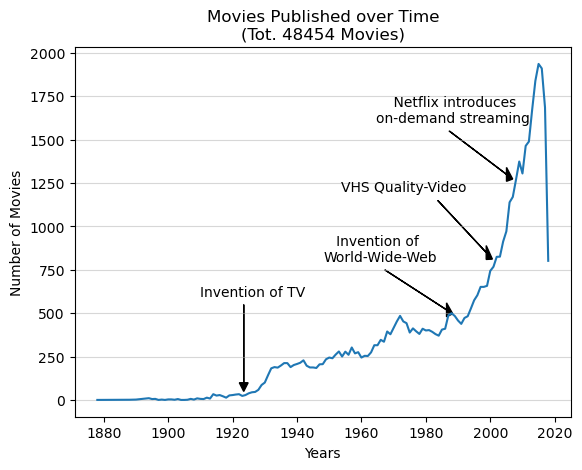

In [15]:
# Count movies published by year
movies_by_year = movies_df.groupby('year')['year'].count()

plt.plot(movies_by_year)
plt.title(f"Movies Published over Time\n(Tot. {len(movies_df)} Movies)")
plt.ylabel('Number of Movies')
plt.xlabel('Years')
plt.grid(axis='y', alpha=.5)
plt.annotate('Invention of TV', xy=(-22000, 600))
plt.arrow(-17000, 550, 0, -450, head_width=1000, head_length=50, color='black')
plt.annotate('   Invention of\nWorld-Wide-Web', xy=(-8000, 800))
plt.arrow(-1000, 750, 7000, -230, head_width=80, head_length=700, color='black')
plt.annotate('VHS Quality-Video', xy=(-6000, 1200))
plt.arrow(5000, 1150, 5500, -300, head_width=80, head_length=700, color='black')
plt.annotate('    Netflix introduces\non-demand streaming', xy=(-2000, 1600))
plt.arrow(6300, 1550, 6500, -250, head_width=80, head_length=700, color='black')
plt.show()

There is a clear positive, even close to exponential, growth of movies published over time. The invention of the television in 1927 definetly played a role in driving the initial growth. However, the television reached a close to 100% household penetration rate already in 1990. Therefore, the strong growth of the TV adoption curve between 1965 and 1985 did not have too much of an impact of the movies produced. In fact, the number of movies started to spike in the 1990s, right after the invention of the world-wide-web. Furthermore, the availability of VHS quality video with reliable lip sync from 2002 and the advent of mass-streaming services like YouTube and Netflix between 2005 and 2010 led the number of movies produced into it's exponential growth phase.

In [16]:
# Get number of movies by genre
genres_df = movies_df[['movieId', 'genres']].explode('genres')
ratings_genres_df = genres_df.merge(ratings_df[['movieId', 'rating']], on='movieId', how='left')
ratings_genres_df = ratings_genres_df.groupby('genres').agg({'rating': 'mean', 'movieId': pd.Series.nunique})
ratings_genres_df.columns = ['avg_rating', 'num_movies_in_genre']

# Get percentage of movies that belongs to each genre
ratings_genres_df['percent_movies_in_genre'] = ratings_genres_df['num_movies_in_genre']/len(movies_df)*100
ratings_genres_df = ratings_genres_df.sort_values('percent_movies_in_genre', ascending=False)

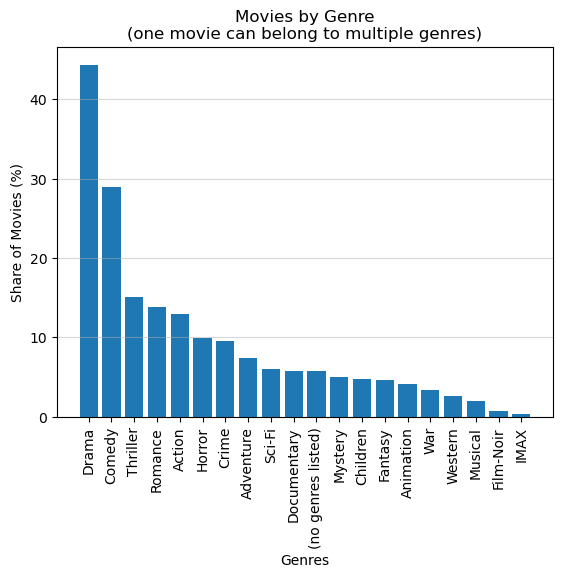

In [17]:
plt.bar(x=ratings_genres_df.index, height=ratings_genres_df['percent_movies_in_genre'])
plt.title('Movies by Genre\n(one movie can belong to multiple genres)')
plt.grid(axis='y', alpha=.5)
plt.ylabel('Share of Movies (%)')
plt.xlabel('Genres')
plt.xticks(rotation=90);

Most movies belong into the drama genre – almost half of all movies have that category assigned to them.

Now, let's look if different genres are rated differently by the users:

In [18]:
# Merge movies with ratings to get rating distribution by genre
genre_ratings = ratings_df[['movieId', 'rating']].merge(movies_df[['movieId', 'genres']], on='movieId', how='left')
genre_ratings = genre_ratings.explode('genres')

In [19]:
# Create a list of unique genres
genres = genre_ratings['genres'].unique()

# Create a figure with a grid of histograms for each genre
fig, axs = plt.subplots(4, 5, figsize=(12, 8), sharex=True)

for i, genre in enumerate(genres):
    row = i // 5
    col = i % 5
    data = genre_ratings[genre_ratings['genres'] == genre]['rating']
    axs[row, col].hist(data, bins=9)
    axs[row, col].grid(alpha=.5)
    axs[row, col].set_title(genre)
    axs[row, col].set_xticks([1, 2, 3, 4, 5]) 

fig.supxlabel('Rating Scores')
fig.supylabel('Number of Ratings')
plt.suptitle('Distribution of Ratings by Genre')
plt.tight_layout();

For most genres, the distribution of rating scores assigned by users looks fairly similar. Most genres recieved mainly ratings of 4.5 but there are some genres that recieved more 5.0 ratings than 4.5 ratings, e.g., Crime, War, and Film-Noir. Interestingly, users seem to dislike rating movies with exactly 4.0 points and prefer going for either 3.5 or 4.5. This pattern is observable among almost all genres.

### 2.2 Movie Tags (tag column)

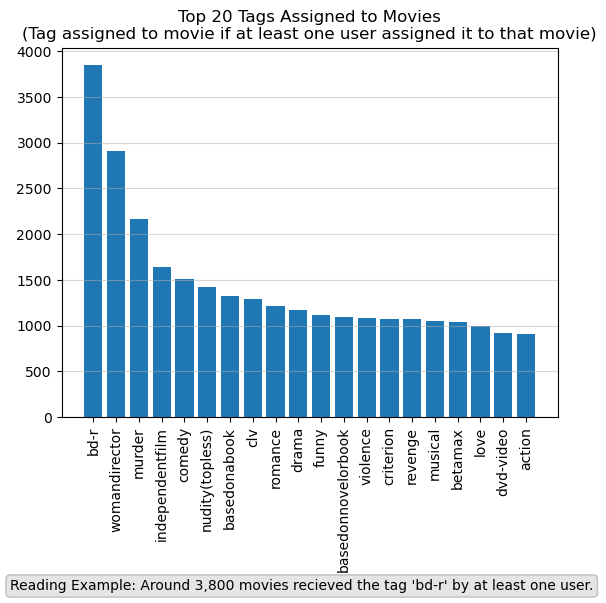

In [20]:
#  Get all assigned tags and show those assigned to most movies
all_tags = movies_df[['movieId', 'title', 'genres', 'tag']].explode('tag')
all_tags_count = all_tags[['tag']].value_counts('tag').sort_values(ascending=False)

fig, ax = plt.subplots()

plt.bar(x=all_tags_count.index[:20], height=all_tags_count[:20])
plt.grid(axis='y', alpha=.5)
plt.title('Top 20 Tags Assigned to Movies\n(Tag assigned to movie if at least one user assigned it to that movie)')
plt.xticks(rotation=90)

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
text = fig.text(0.5, -.25, 'Reading Example: Around 3,800 movies recieved the tag \'bd-r\' by at least one user.',
                horizontalalignment='center', wrap=True, bbox=props);

This plot shows the top 20 tags that were assigned to most movies. A tag counts as 'assigned to a movie' if at least one user assigned the tag to that movie. Notably, the tag assigned most often does not have anything to do with the content of the movie as 'bd-r' referes to Blu-Ray technology and probably indicates that the move had been available on Blu-Ray. Even though Blu-Ray technology is not as popular as it used to be and major firms in the market discountinued the production of Blu-Ray players (e.g., Samsung in 2019), the pattern is not surprising as the rating data contains a lot of ratings between 2006 (when Blu-Ray was made available to the market) and 2019 (when players started discontinueing the technology).

Now, let's compare the top 10 tags between genres.

In [21]:
# Count most relevant tags by genre
all_tags_by_genre = all_tags.explode('genres')
all_tags_by_genre = all_tags_by_genre.groupby(['genres', 'tag'])['movieId'].count().reset_index()
all_tags_by_genre = all_tags_by_genre.sort_values(['genres', 'movieId'], ascending=[False, False])
all_tags_by_genre.rename(columns={'movieId': 'tag_count'}, inplace=True)

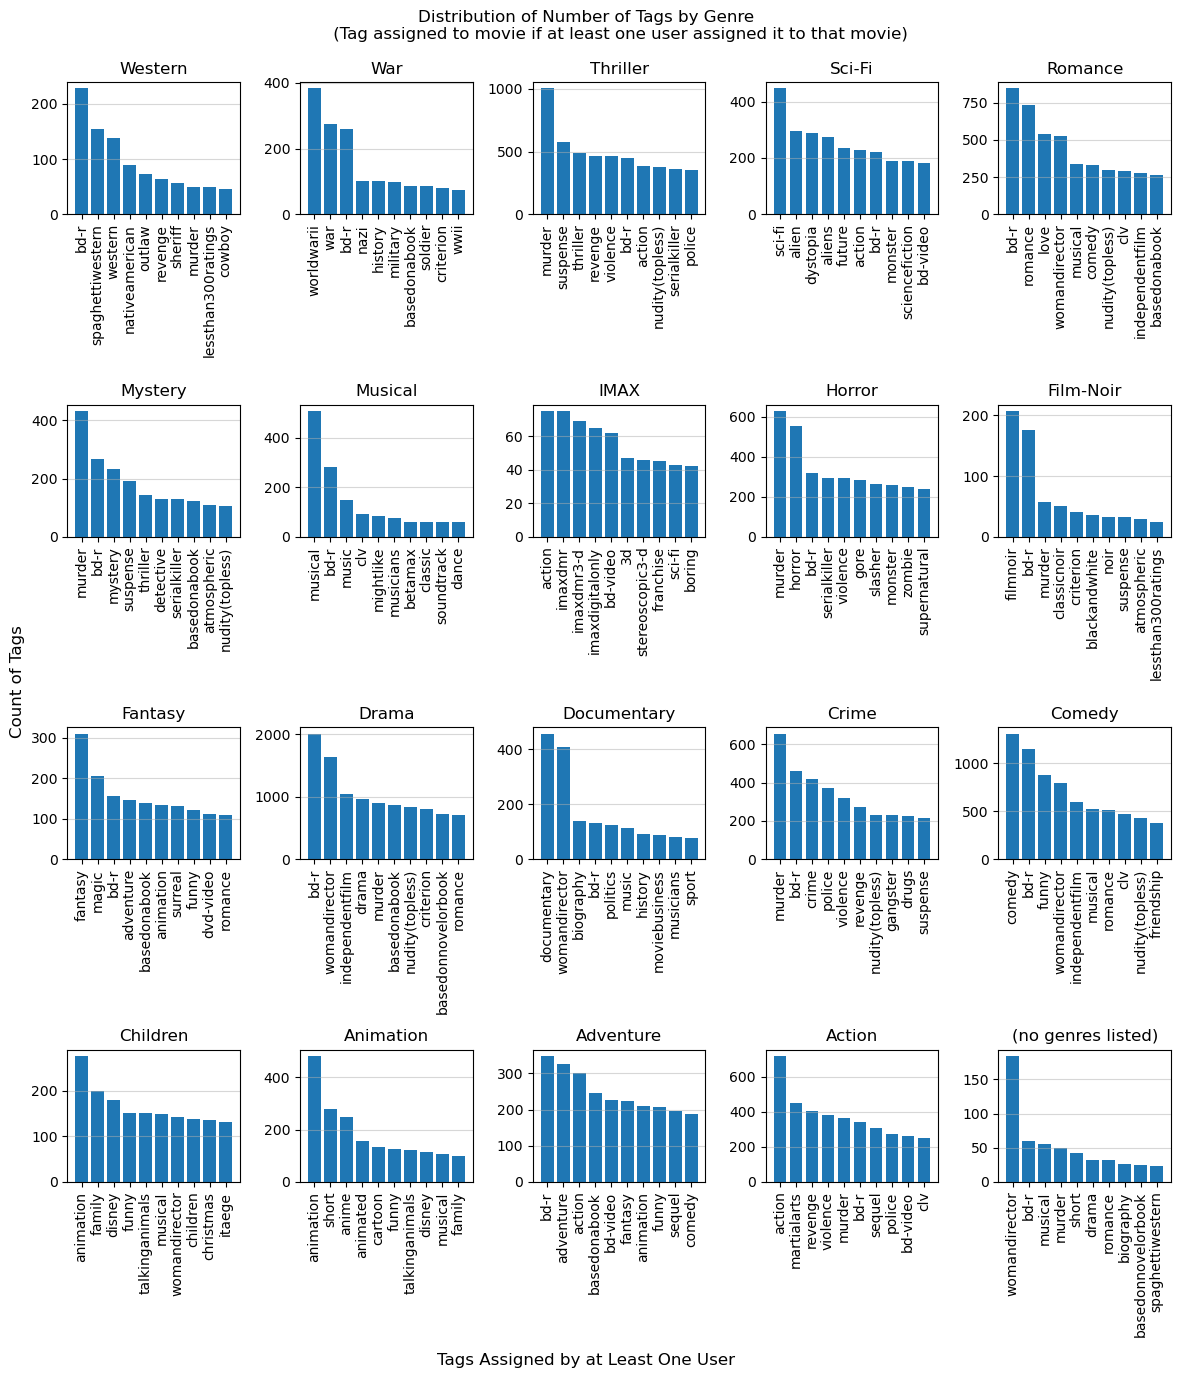

In [22]:
# Create a figure with a grid of histograms for each genre
fig, axs = plt.subplots(4, 5, figsize=(12, 14), sharex=False)

# Iterate over each genre and plot a histogram
for i, genre in enumerate(all_tags_by_genre['genres'].unique()):
    
    row = i // 5
    col = i % 5
    x_ticks = all_tags_by_genre[all_tags_by_genre['genres'] == genre]['tag'][:10]
    y_height = all_tags_by_genre[all_tags_by_genre['genres'] == genre]['tag_count'][:10]
    axs[row, col].bar(x=x_ticks, height=y_height)
    axs[row, col].set_title(genre)
    axs[row, col].grid(axis='y', alpha=.5)
    axs[row, col].set_xticks(range(len(x_ticks)))
    axs[row, col].set_xticklabels(x_ticks, rotation=90)
    
plt.suptitle("""Distribution of Number of Tags by Genre
             (Tag assigned to movie if at least one user assigned it to that movie)
             """)
fig.supxlabel('Tags Assigned by at Least One User')
fig.supylabel('Count of Tags')
plt.tight_layout();

We note that the most assigned tag overall is not the most assigned tag for each genre. The genre name is always among the top 10 tags. Most of the tags are not that surprising and describe the genres as one would expect. However, some tags reveal similarities between genres. For example, both Horror and Crime movies have murder as their top tag.

### 2.3 Movie Directors (director column)

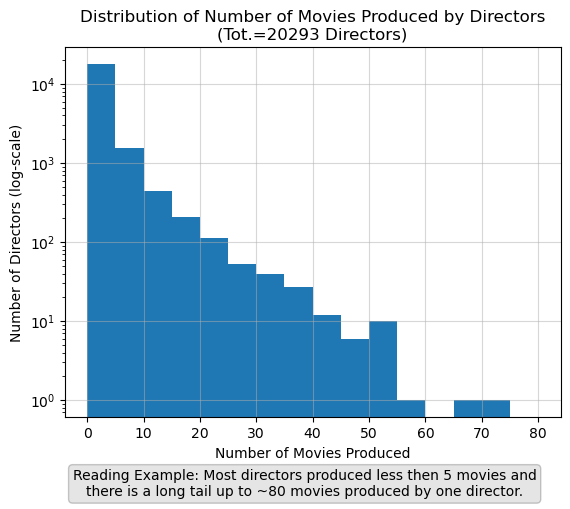

In [23]:
# Get all directors and show distribution of how many films they produced
directors_df = movies_df[['director']].explode('director')
directors_df = directors_df.groupby('director').agg({'director': 'count'})
directors_df.columns = ['count']
directors_df = directors_df.sort_values(by='count', ascending=False)

fig, ax = plt.subplots()

plt.hist(directors_df, range=(0,80), bins=16)
plt.title(f"Distribution of Number of Movies Produced by Directors\n(Tot.={len(directors_df)} Directors)")
plt.ylabel('Number of Directors (log-scale)')
plt.xlabel('Number of Movies Produced')
plt.yscale('log')
plt.grid(alpha=.5)

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
text = fig.text(0.50, -.05,
                'Reading Example: Most directors produced less then 5 movies and\nthere is a long tail up to ~80 movies produced by one director.',
                horizontalalignment='center', wrap=True, bbox=props);

Most directors produced between one and five movies. The distribution is highly right-skewed and there is only a very small number of highly productive directors, e.g., only two directors produced more than 60 movies in the dataset. However, seing a distribution of what percentage of directors produced more than n movies would help to get an even better understanding uf the distribution.

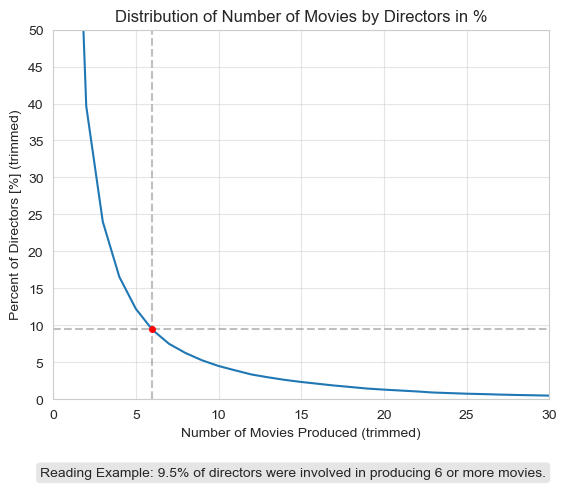

In [46]:
directors_n_movies = instances_n_observations(data=directors_df, range_=(1, 81))

fig, ax = plt.subplots()
plt.plot(directors_n_movies['n'],
         directors_n_movies['instances with >= n observations (%)'])
plt.grid(alpha=.5)
plt.title('Distribution of Number of Movies by Directors in %')
plt.ylabel('Percent of Directors [%] (trimmed)')
plt.yticks([n*5 for n in range(21)])
plt.xlabel('Number of Movies Produced (trimmed)')
plt.xticks([n*5 for n in range(17)])
plt.xlim(0,30)
plt.ylim(0,50)
plt.hlines(9.5, 0, 30, color='gray', linestyle='--', alpha=.5)
plt.vlines(6, 0, 50, color='gray', linestyle='--', alpha=.5)
plt.plot(6, 9.5, marker='o', color='r', markersize=4)
props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
text = fig.text(0.50, -.05, 'Reading Example: 9.5% of directors were involved in producing 6 or more movies.',  horizontalalignment='center', wrap=True, bbox=props) 
plt.show()

We note that the distribution converges with zero quite quickly. Only about 10% of directors produced more than 6 movies of those present in the dataset. Let's look a the positive outliers, i.e., the most productive directors in the dataset, more closely.

In [25]:
print("The Top 10 Most Productive Directors in the Dataset are:")
directors_df_10 = directors_df.head(10).reset_index()
directors_df_10.index = range(1,11)
directors_df_10

The Top 10 Most Productive Directors in the Dataset are:


director  count
1     Michael Curtiz     71
2          John Ford     67
3     Richard Thorpe     57
4    Jean-Luc Godard     54
5        Raoul Walsh     53
6     Henry Hathaway     53
7   Alfred Hitchcock     53
8       Mervyn LeRoy     52
9      Werner Herzog     51
10    Gordon Douglas     50

### 2.4 Movie Actors (actors column)

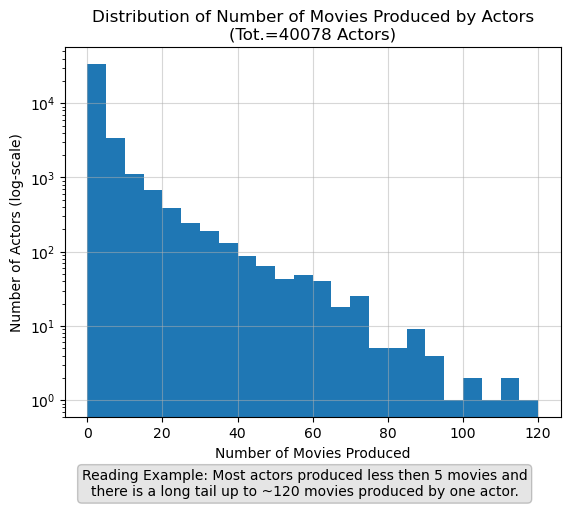

In [26]:
# Get all actors and show distribution of how many films they participated in

actors_df = movies_df[['actors']].explode('actors')
actors_df = actors_df.groupby('actors')[['actors']].count()
actors_df.columns = ['count'] 
actors_df = actors_df.sort_values('count', ascending=False)

fig, ax = plt.subplots()

plt.hist(actors_df, range=(0,120), bins=24)
plt.grid(alpha=.5)
plt.title(f"Distribution of Number of Movies Produced by Actors\n(Tot.={len(actors_df)} Actors)")
plt.yscale('log')
plt.ylabel('Number of Actors (log-scale)')
plt.xlabel('Number of Movies Produced')

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
text = fig.text(0.50, -.05,
                'Reading Example: Most actors produced less then 5 movies and\nthere is a long tail up to ~120 movies produced by one actor.',
                horizontalalignment='center', wrap=True, bbox=props);

Most actors participated in between one and five movies. The distribution is highly right-skewed and there is only a very small number of highly productive actors. But overall the actors seem more productive than the directors in terms of who has interactions with most movies on average. This is because most movies have multiple actors starring but only one director. However, seing a distribution of what percentage of actors participated in more than n movies would help to get an even better understanding uf the distribution.

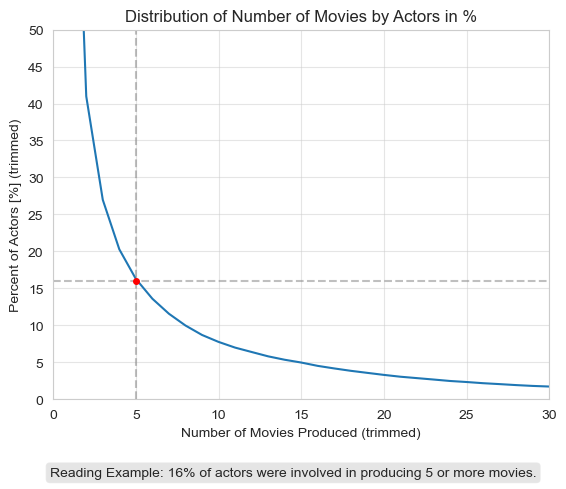

In [47]:
actors_n_movies = instances_n_observations(data=actors_df, range_=(1, 121))

fig, ax = plt.subplots()

plt.plot(actors_n_movies['n'],
         actors_n_movies['instances with >= n observations (%)'])
plt.grid(alpha=.5)
plt.title('Distribution of Number of Movies by Actors in %')
plt.ylabel('Percent of Actors [%] (trimmed)')
plt.yticks([n*5 for n in range(21)])
plt.xlabel('Number of Movies Produced (trimmed)')
plt.xticks([n*5 for n in range(25)])
plt.xlim(0,30)
plt.ylim(0,50)
plt.hlines(16, 0, 120, color='gray', linestyle='--', alpha=.5)
plt.vlines(5, 0, 100, color='gray', linestyle='--', alpha=.5)
plt.plot(5, 16, marker='o', color='r', markersize=4)
props = dict(boxstyle='round', facecolor='gray', alpha=0.2)

text = fig.text(0.50, -.05, 'Reading Example: 16% of actors were involved in producing 5 or more movies.',
                horizontalalignment='center', wrap=True, bbox=props);

The plot confirms above intuition, it converges to zero more slowly than the equivalent plot for the directors. Now let's examine the most productive actors in more detail:

In [28]:
print("The Top 10 Most Productive Actors in the Dataset are:")
actors_df_10 = actors_df.head(10).reset_index()
actors_df_10.index = range(1,11)
actors_df_10

The Top 10 Most Productive Actors in the Dataset are:


actors  count
1        Frank Welker    156
2        Bess Flowers    146
3       Clarence Nash    145
4      John Carradine    134
5     Christopher Lee    130
6          John Wayne    121
7   Samuel L. Jackson    120
8    Gérard Depardieu    113
9           Ward Bond    111
10     Robert De Niro    106

### 2.5 Movie Durations (runtime column)

In [49]:
# SHow distribution of movie runtime
fig, ax = plt.subplots()

plt.hist(movies_df['runtime'], range=(0,200), bins=20)
plt.grid(alpha=.5)
plt.title('Distribution of Movie Durations')
plt.xlabel('Runtime (trimmed)')
plt.ylabel('Number of Movies')
plt.xticks([n*20 for n in range(11)])
plt.vlines(np.mean(movies_df['runtime']), ymin=0, ymax=14000, color='red')
plt.annotate(f"Mean: {round(np.mean(movies_df['runtime']), 1)} min", xy=(99, 14000))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
text = fig.text(0.50, -.05, 'Reading Example: Most movies (almost 14,000) have a duration of 90-100 minutes.',
                horizontalalignment='center', wrap=True, bbox=props);


The movie runtime is normally distributed around 95-100 minutes with the mean being 96.6 minutes. There are a few short movies under 10 minutes and a very small number of very long movies, which is why the x-axis has been trimmed.

### 2.6 Production Countries (production_countries column)

In [30]:
# Show number of movies by production country
countries_df = movies_df[['movieId', 'production_countries']].explode('production_countries')
countries_df = countries_df.groupby('production_countries')['movieId'].count().sort_values(ascending=False)

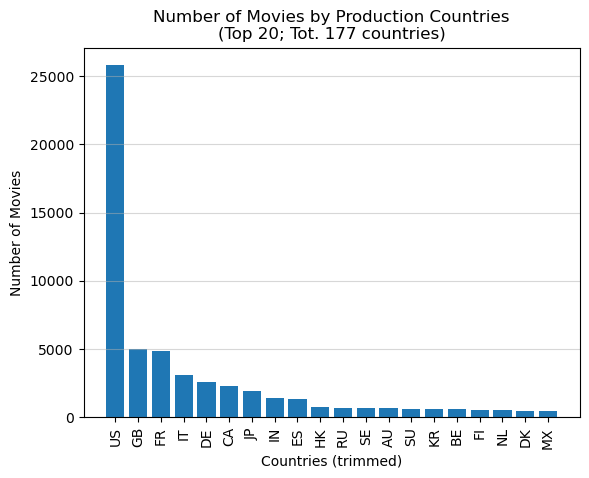

In [31]:
plt.bar(x=countries_df.index[:20], height=countries_df[:20])
plt.title(f"Number of Movies by Production Countries\n(Top 20; Tot. {len(countries_df)} countries)")
plt.grid(axis='y', alpha=.5)
plt.ylabel('Number of Movies')
plt.xlabel('Countries (trimmed)')
plt.xticks(rotation=90);

The US is by far the country with most movies produced, followed by 4 European countries. The first Asian country, Japan, is seventh.

### 2.7 Languages Spoken (spoken_languages column)

In [32]:
# Show number of movies with each language spoken
languages_df = movies_df[['movieId', 'spoken_languages']].explode('spoken_languages')
languages_df = languages_df.groupby('spoken_languages')['movieId'].count().sort_values(ascending=False)

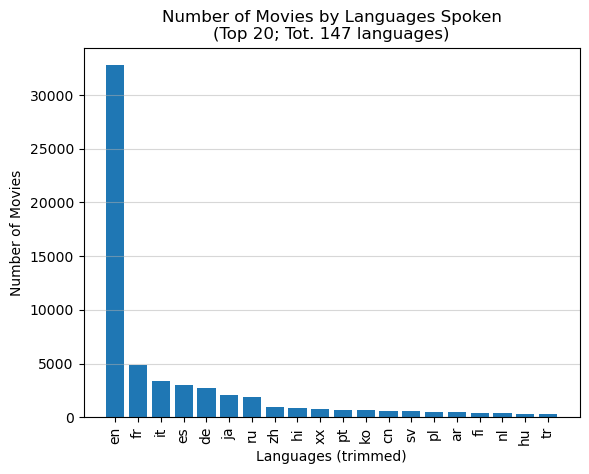

In [33]:
plt.bar(x=languages_df.index[:20], height=languages_df[:20])
plt.title(f"Number of Movies by Languages Spoken\n(Top 20; Tot. {len(languages_df)} languages)")
plt.grid(axis='y', alpha=.5)
plt.ylabel('Number of Movies')
plt.xlabel('Languages (trimmed)')
plt.xticks(rotation=90);

Unsurprisingly, most movies have english as their primary language. Interestingly, mute movies, usually produced in the early days, are still among the top 10.

### 2.8 Movie Plot Descriptions (description and description analysis columns)

In [34]:
# Show detailed analysis of movie description texts
description_colnames = ['description'] + list(movies_df.columns)[-18:]
description_cols = movies_df.loc[:, description_colnames]
description_cols.describe()

description_nwords  description_nwords_wsw  description_nwords_unique  \
count        48454.000000            48454.000000               48454.000000   
mean            50.301791               28.448632                  26.424299   
std             30.913828               17.269297                  14.957552   
min              2.000000                1.000000                   1.000000   
25%             26.000000               15.000000                  15.000000   
50%             43.000000               24.000000                  23.000000   
75%             67.000000               38.000000                  35.000000   
max            188.000000              133.000000                 113.000000   

       description_nstopwords  description_diff_nwords  description_meanword  \
count            48454.000000             48454.000000          48454.000000   
mean                21.853160                28.448632              4.869493   
std                 14.380021                17.269297              0.481325   
min                 -2.000000                 1.000000              2.571429   
25%                 11.000000                15.000000              4.547619   
50%                 18.000000                24.000000              4.833333   
75%                 29.000000                38.000000              5.142857   
max                103.000000               133.000000             12.000000   

       description_meanword_wsw  description_nchars  description_nchars_wsw  \
count              48454.000000        48454.000000            48454.000000   
mean                   6.271610          292.080819              204.833595   
std                    0.636463          178.920397              124.555687   
min                    3.000000           13.000000                3.000000   
25%                    5.849352          152.000000              109.000000   
50%                    6.233333          247.000000              174.000000   
75%                    6.647059          391.000000              273.000000   
max                   11.500000         1000.000000              869.000000   

       description_diff_nchars  description_jj_n  description_nn_n  \
count             48454.000000      42456.000000      42456.000000   
mean                 87.247224          2.952186         20.341389   
std                  58.639449          2.405794         12.468692   
min                   0.000000          0.000000          1.000000   
25%                  42.000000          1.000000         11.000000   
50%                  73.000000          2.000000         17.000000   
75%                 118.000000          4.000000         27.000000   
max                 400.000000         23.000000        134.000000   

       description_prp_n  description_rb_n  description_vb_n  
count       42456.000000      42456.000000      42456.000000  
mean            3.108936          2.201055          4.788934  
std             2.975142          2.304077          3.918429  
min             0.000000          0.000000          0.000000  
25%             1.000000          0.000000          2.000000  
50%             2.000000          2.000000          4.000000  
75%             4.000000          3.000000          7.000000  
max            25.000000         26.000000         29.000000

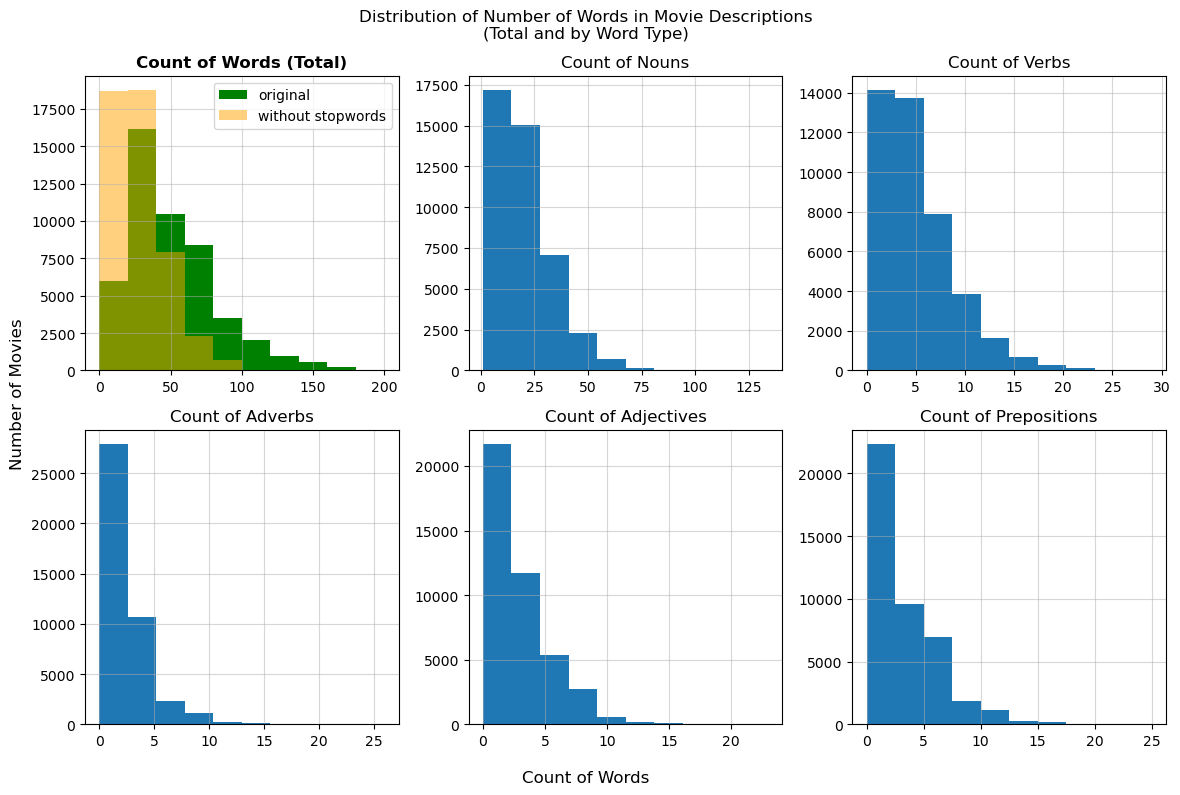

In [35]:
# Create a figure with a grid of histograms for each genre
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=False)

# Iterate over each genre and plot a histogram
for i, column in enumerate(['description_nwords',
                            'description_nn_n',
                            'description_vb_n',
                            'description_rb_n',
                            'description_jj_n',
                            'description_prp_n']):
    
    title_dict = {'description_nwords': 'Count of Words (Total)',
                  'description_jj_n': 'Count of Adjectives',
                  'description_nn_n': 'Count of Nouns',
                  'description_prp_n': 'Count of Prepositions',
                  'description_rb_n': 'Count of Adverbs',
                  'description_vb_n': 'Count of Verbs'}
    row = i // 3
    col = i % 3
    data = movies_df[column]
    if row == 0 and col == 0:
        axs[row, col].hist(data, color='green', range=(0,200),
                          label='original')
        axs[row, col].hist(movies_df['description_nwords_wsw'],
                           range=(0,200),
                           color='orange',
                           label='without stopwords',
                           alpha=.5)
        axs[row, col].legend()
        axs[row, col].set_title(title_dict[column], fontweight='bold')
    else:
        axs[row, col].hist(data)
        axs[row, col].set_title(title_dict[column])
    axs[row, col].grid(alpha=.5)
    
fig.supxlabel('Count of Words')
fig.supylabel('Number of Movies')
plt.suptitle('Distribution of Number of Words in Movie Descriptions\n(Total and by Word Type)')
plt.tight_layout();

Most movie descriptions have a length of under 50 words. Nouns and Verbs are the most frequent words types and may contain some insightfuls information on the movies. Therefore, let's look at freqently used terms in detail by analyzing Unigrams, Bigrams, and Trigrams. These insights will help us in determining the parameters to apply in the CountVectorizer for feature generation:

In [36]:
ngrams_df = movies_df[['movieId', 'genres', 'description_root_wrds']].explode('genres')

def generate_ngrams(text, n_gram):
    n_gram_dict = {}
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    n_gram_list = [' '.join(ngram) for ngram in ngrams]
    for term in n_gram_list:
        if term in n_gram_dict.keys():
            n_gram_dict[term] += 1
        else:
            n_gram_dict[term] = 1
    n_gram_df = pd.DataFrame(columns=['term_count'], index=n_gram_dict.keys(), data=n_gram_dict.values())
    n_gram_df_sorted = n_gram_df.sort_values('term_count', ascending=False)
    return n_gram_df_sorted

In [37]:
global_unigrams = generate_ngrams(' '.join(movies_df['description_root_wrds'].astype('str')), 1)

plt.barh(y=global_unigrams.sort_values('term_count').index[-20:],
         width=global_unigrams.sort_values('term_count')['term_count'][-20:])
plt.grid(axis='x', alpha=.5)
plt.title('Top 20 Unigrams in Movie Descriptions')
plt.ylabel('Unigrams')
plt.xlabel('Count of Occurences');

Analyzing the Unigrams, we identify that the term "life" is the one appearing most frequently. However, as it appears in at most ~20% of descriptions, it cannot be considered a corpus specific stopword. This makes all top Unigrams feasible to include into the feature engineering. 

In [38]:
global_bigrams = generate_ngrams(' '.join(movies_df['description_root_wrds']), 2)

plt.barh(y=global_bigrams.sort_values('term_count').index[-20:],
         width=global_bigrams.sort_values('term_count')['term_count'][-20:])
plt.grid(axis='x', alpha=.5)
plt.title('Top 20 Bigrams in Movie Descriptions')
plt.ylabel('Bigrams')
plt.xlabel('Count of Occurences');

There are several valuable bigrams in the dataset that should be included in the feature engineering part. However, upon inspection of all bigrams in a separate file, a very long tail can be observed. There is a large share of bigrams that occurs below 5 times making a large share of bigrams unsuitable for feature engineering. Accordingly, a min_df parameter must be specified when, for example, applying the CountVectorizer function.

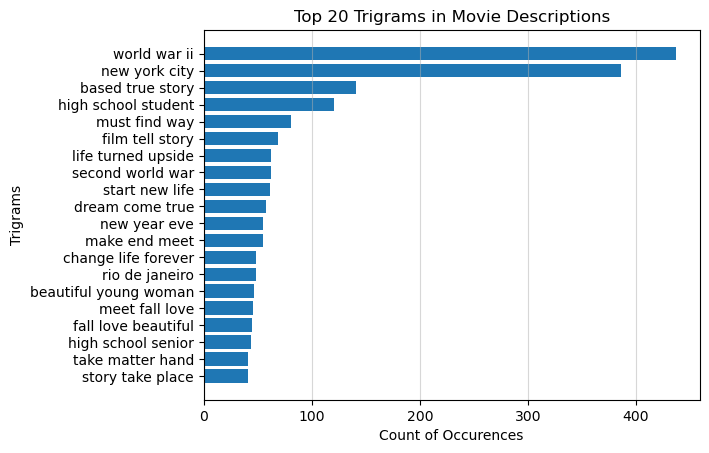

In [39]:
global_trigrams = generate_ngrams(' '.join(movies_df['description_root_wrds']), 3)

plt.barh(y=global_trigrams.sort_values('term_count').index[-20:],
         width=global_trigrams.sort_values('term_count')['term_count'][-20:])
plt.grid(axis='x', alpha=.5)
plt.title('Top 20 Trigrams in Movie Descriptions')
plt.ylabel('Trigrams')
plt.xlabel('Count of Occurences');

The Trigrams behave simliar to the Bigrams. There are several valuable Trigrams in the dataset that should be included in the feature engineering part. However, upon inspection of all Trigrams in a separate file, shows an even longer tail than for Bigrams. This emphasizes the need to specify a min_df parameter when, for example, applying the CountVectorizer function.

In [40]:
# Save all Unigrams, Bigrams, and Trigrams occuring more than 1 to inspect patterns more closely
with pd.ExcelWriter('../00_Data/01_processed/n_grams.xlsx') as writer:
    global_unigrams[global_unigrams['term_count'] > 1].to_excel(writer, sheet_name='Unigrams')
    global_bigrams[global_bigrams['term_count'] > 1].to_excel(writer, sheet_name='Bigrams')
    global_trigrams[global_trigrams['term_count'] > 1].to_excel(writer, sheet_name='Trigrams')

In [41]:
ngrams_df = movies_df[['movieId', 'genres', 'description_root_wrds']].explode('genres')

def generate_ngrams(text, n_gram):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 10

# Dict of Top 10 Unigrams per genre

def create_ngram_df_dict(column, grams):
    ''' creates a dictionary of dataframes with categories as keys
    and dataframes with ngrams as columns'''
    dict_ = {}
    for genre in ngrams_df['genres'].unique():
        genre_ngrams = defaultdict(int)
        for event in ngrams_df[ngrams_df['genres'] == genre][column]:
            for word in generate_ngrams(event, grams):
                genre_ngrams[word] += 1
        dict_[genre] = pd.DataFrame(sorted(genre_ngrams.items(), key=lambda x: x[1])[::-1])
    return dict_

# Set order of categories
order = list(ratings_genres_df.index)

def plot_dict_horizontal_bar_chart(dictionary, grams='N', N=10, rows=4, cols=5):
    '''Plots the top N ngrams per genre in a single figure with multiple subplots'''
    sns.set_style('whitegrid')

    fig, axes = plt.subplots(rows, cols, figsize=(50, 50))
    fig.subplots_adjust(hspace=0.4, wspace=1.2)
    plt.suptitle(f"Top 10 {str(grams)}-Grams by Genre", fontsize=40, fontweight='bold', y=.93)

    for i, (key, df) in enumerate(dictionary.items()):
        if i >= rows * cols:
            break
        
        row, col = divmod(i, cols)
        df = df.head(N).sort_values(1, ascending=False)
        sns.barplot(y=df[0], x=df[1], ax=axes[row, col], color='C0')
        axes[row, col].xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
        axes[row, col].set_title(str(key.title()) + '\n', fontsize=30, fontweight="bold")
        axes[row, col].set_xlabel('Number of Occurrences', fontsize=30, fontweight="bold")
        axes[row, col].set_ylabel('Words', fontsize=30, fontweight="bold")
        axes[row, col].tick_params(axis='y', labelsize=25)
        axes[row, col].tick_params(axis='x', labelsize=25)

    plt.show()

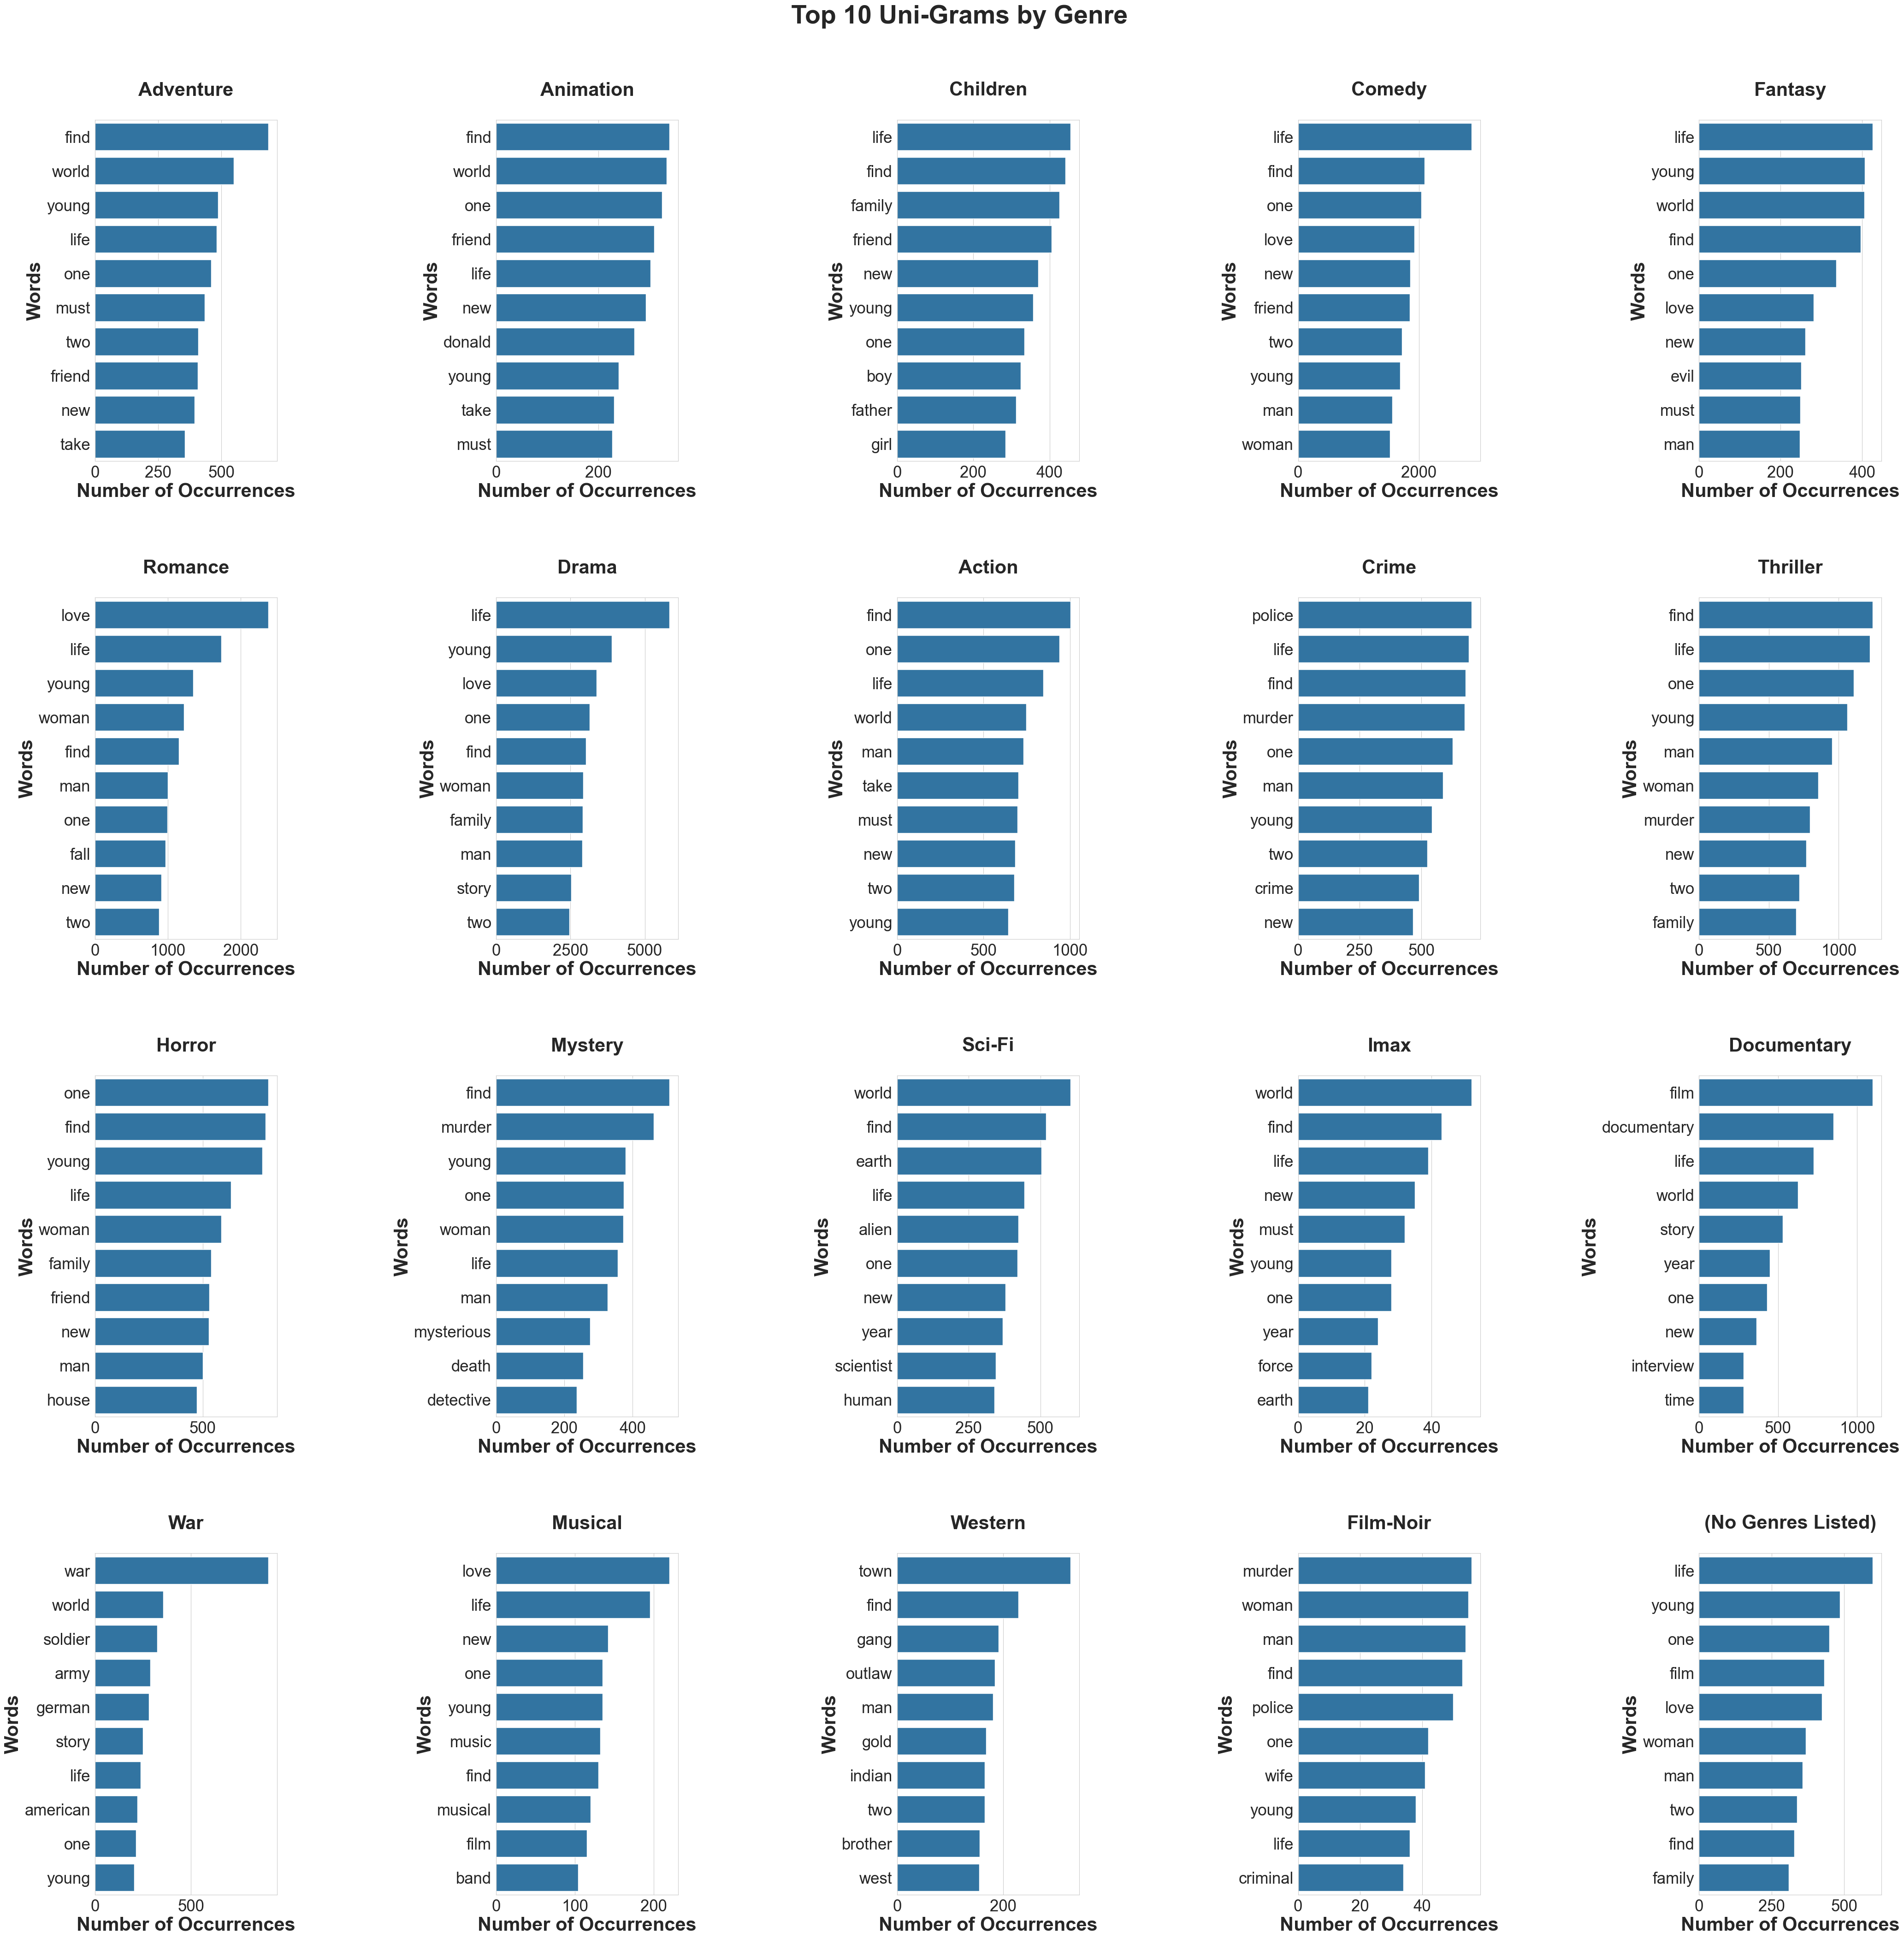

In [42]:
# Create and plot Unigrams for each genre
descriptions_unigram_dfs = create_ngram_df_dict('description_root_wrds', 1)
plot_dict_horizontal_bar_chart(descriptions_unigram_dfs, grams='Uni')

'Find' and 'life' are the the top 1 word used in many genres and quite relevant for all genres. However there are also some words that are quite specific for the genre they fall into, such as the terms 'alien' and 'scientist' in science fiction movies. Now, let's look the the same evaluation for two consecutive words.

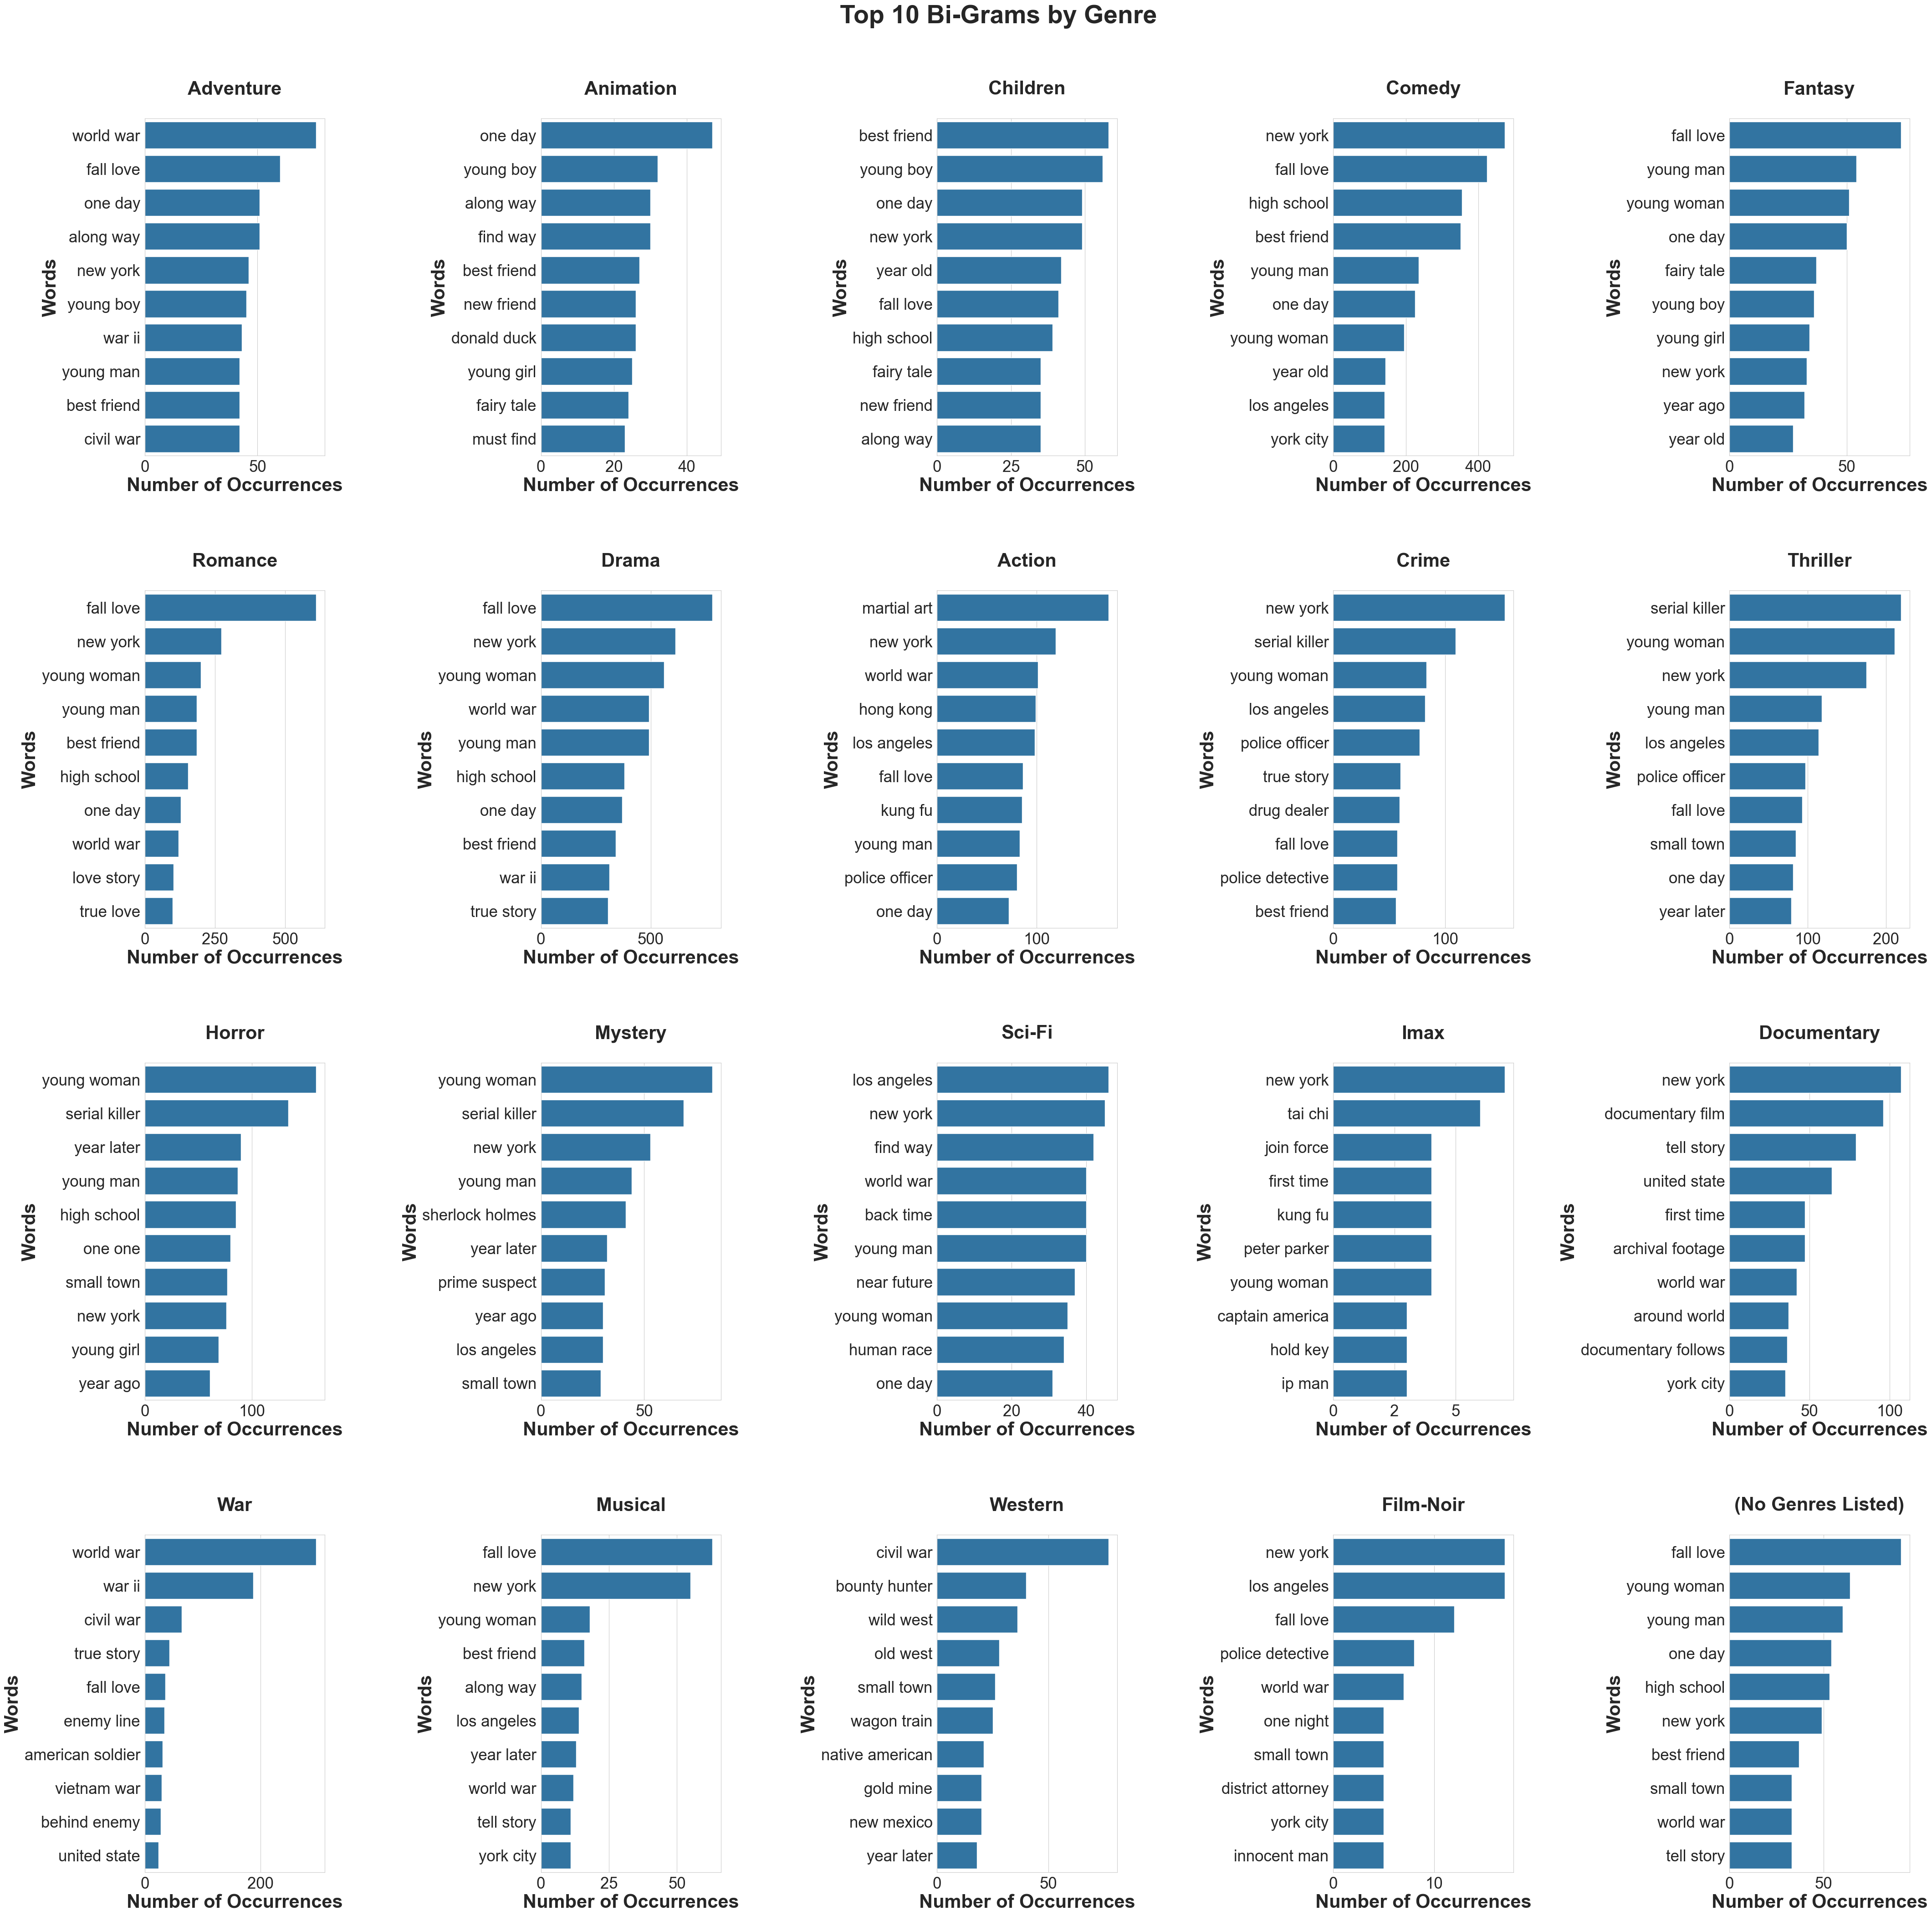

In [43]:
# Create and plot Bigrams for each genre
descriptions_bigram_dfs = create_ngram_df_dict('description_root_wrds', 2)
plot_dict_horizontal_bar_chart(descriptions_bigram_dfs, grams='Bi')

New York seems to be the by far most interesting city for producing movies. The topic 'world war' also seems quite popular and shared across multiple genres. Again, some of the bigrams are rather unsurprising, for example, 'fall love' as number one for romance movies.

Now let's run the same analysis one last time for combinations of three words.

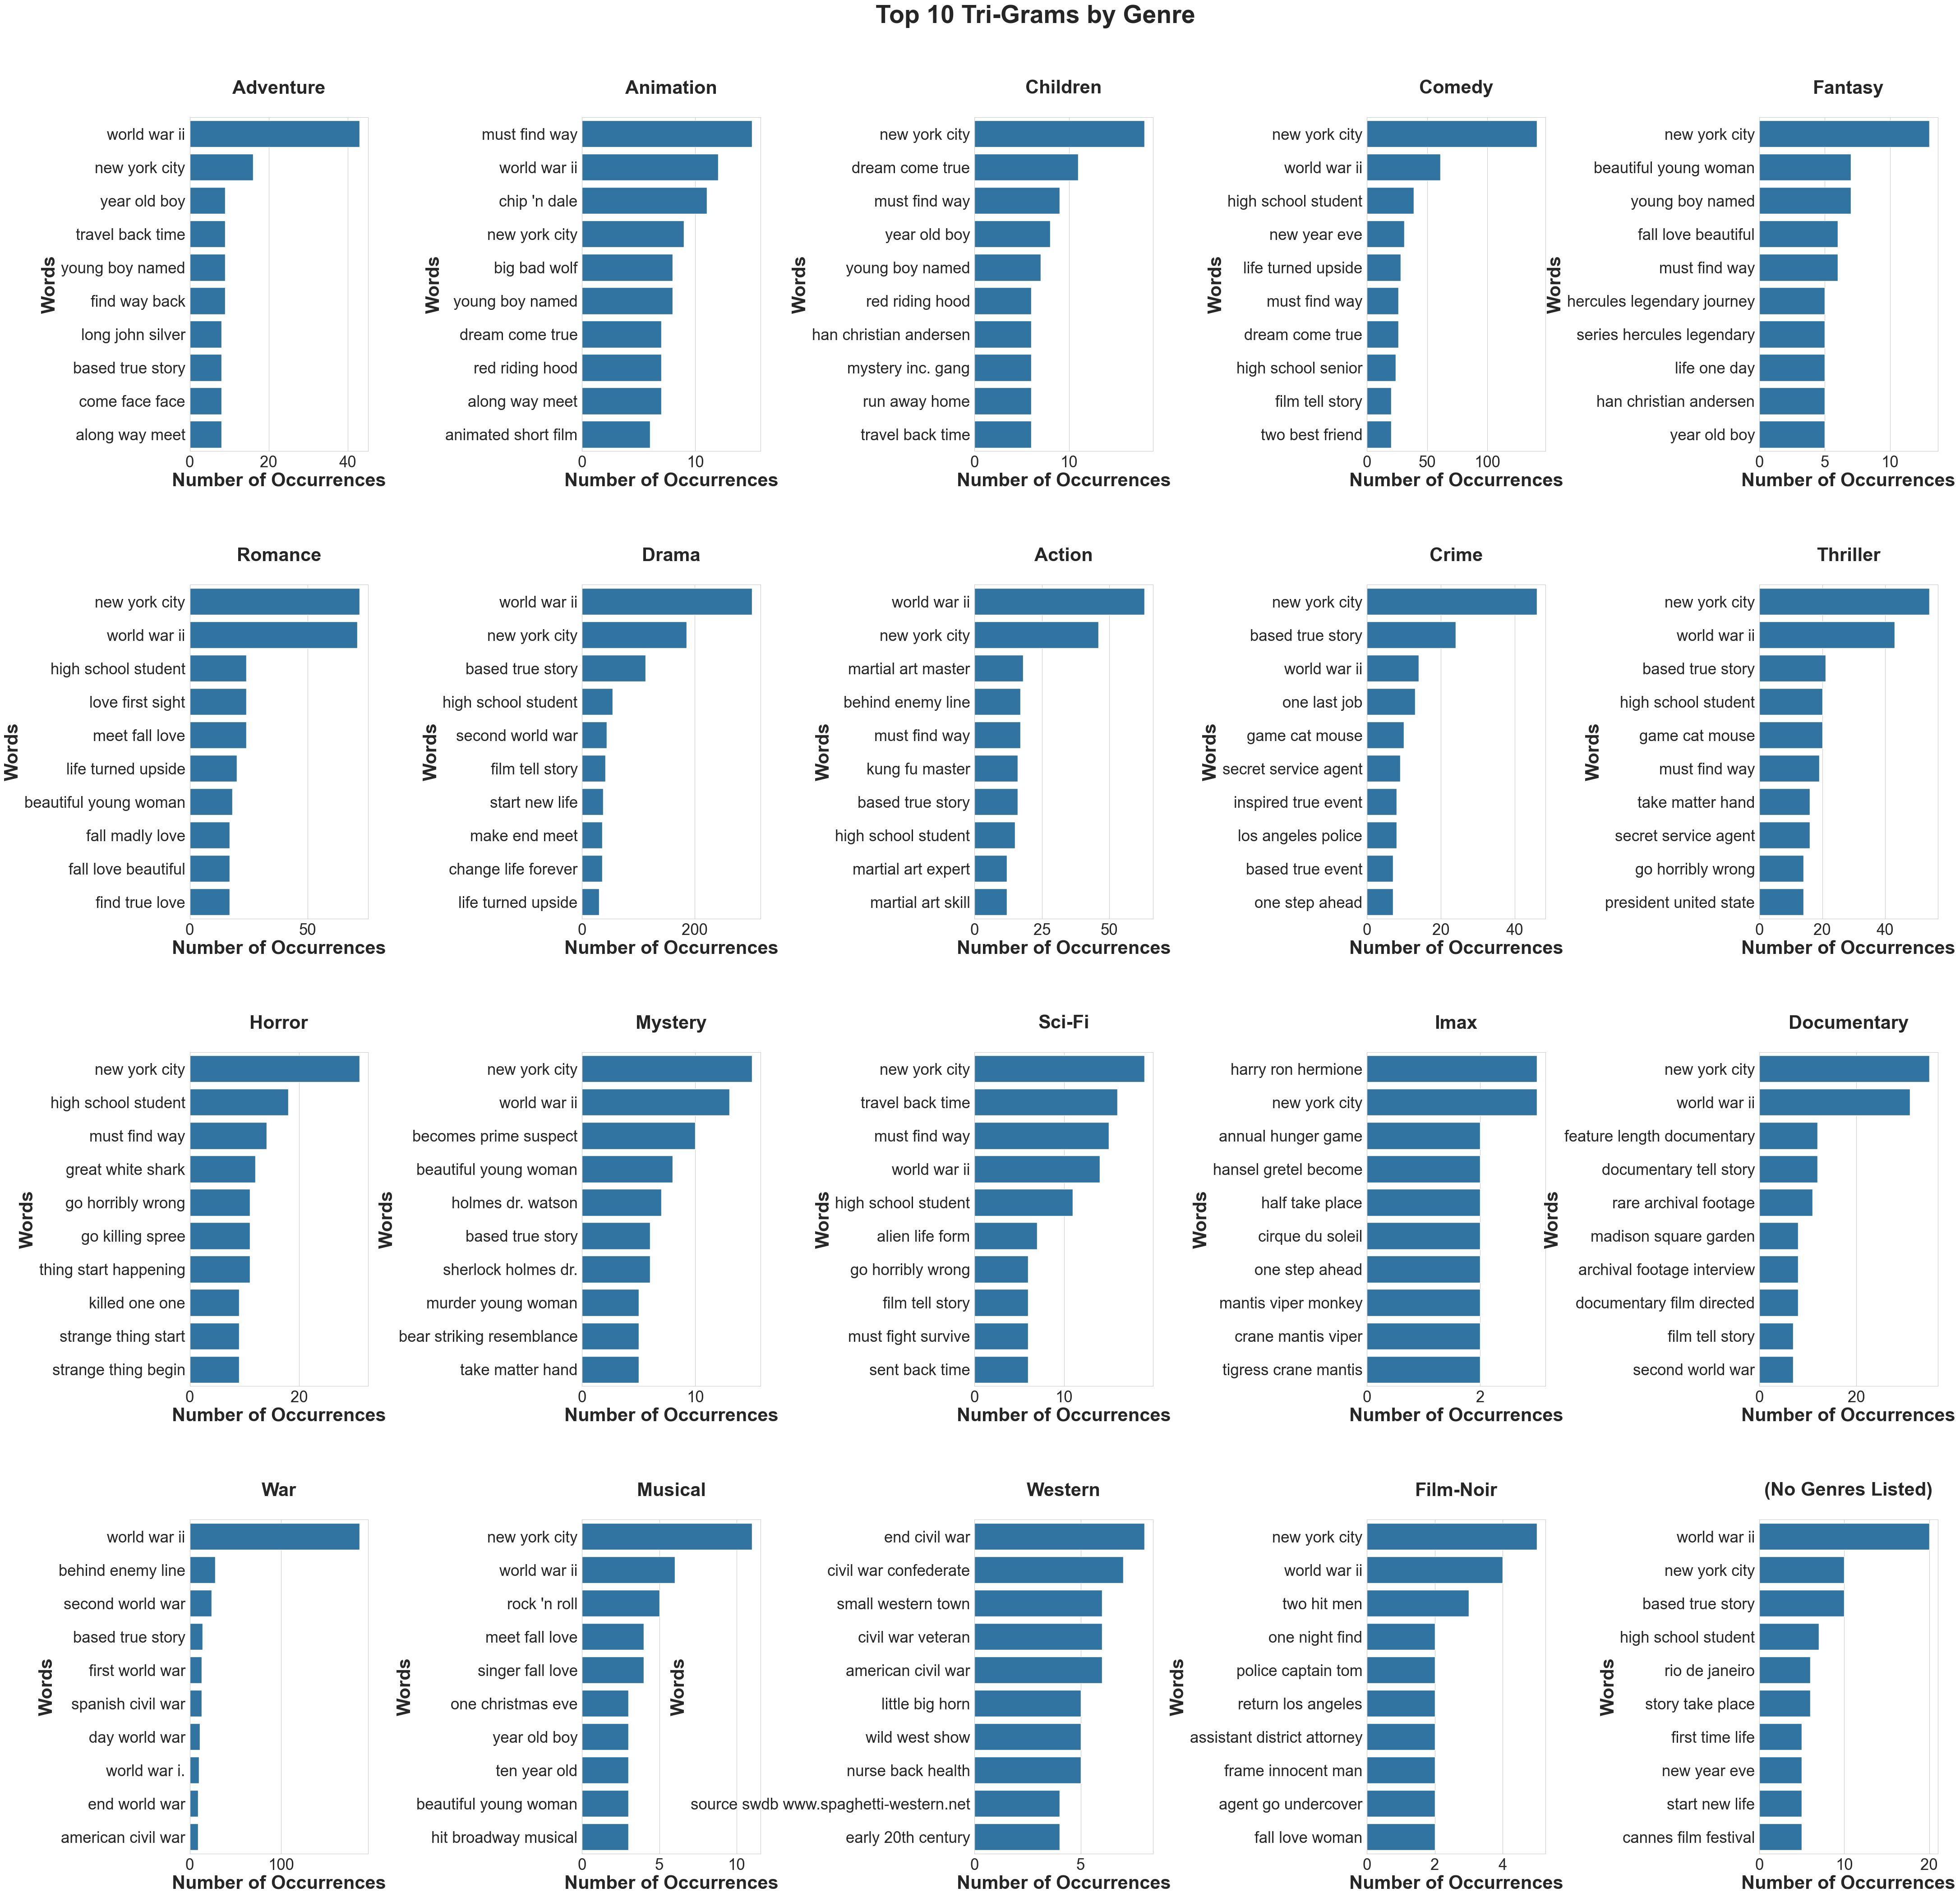

In [44]:
# Create and plot Trigrams for each genre
descriptions_trigram_dfs = create_ngram_df_dict('description_root_wrds', 3)
plot_dict_horizontal_bar_chart(descriptions_trigram_dfs, grams='Tri')

The relevance of new york city and world wars, more specifically World War II, remains confirmed to be shared across multiple genres. However, we also notice how conbinations of three words do not repeat as often and we get quite specific results such as 'harry ron hermoine' which are specific to certain movies or movie collections.

## Wrap-Up

All in all, the dataset is of high quality and looks promising for both building a ratings-based and a content-based recommender system. On the one hand, it has a large number of ratings per user and, in fact, most users rated a significant amount of movies, allowing for insightful similarity calculations. On the other hand there is quite a lot of information on the movie characteristics and contents. The information on the movies allowed us to drill down from very general observations auch as the genre to very specific insights on relevant topics within one specific genre or even shared across different genres. These information and insights will be valuable in generating features for a successful content-based recommender system.

For example, we learned that whenerver functions such as the CountVectorizer for feature engineering are applied, setting max_df parameter is probably not necessary as there are no terms that can be considered corpus specific stopwords left after processing the data for this EDA. However, setting the min_df paramater will be necessary to overcome the large tail of Bigrams and Trigrams. While some columns, such as language, are quite homogeneous, there are quite some columns differentiating the movies from each other and providing a good basis of analysis. For example, genres, descriptions, actors, and directors look very promising for similarity analysis. The next step will be engineering features from the data for model training.